In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

### Model Combination and Bayesian Model Averaging

In earlier chapters, we have explored a range of different models for solving classification and regression problems. It is often found that improved performance can be obtained by combining multiple models together in some way, instead of just using a single model in isolation. For instance, we might train $L$ different models and then make predictions using the average of the predictions made by each model. Such combinations of models are sometimes called **committees**. In Section 14.2, we discuss ways to apply the committee concept in practice and provide insight into why it can sometimes be an effective procedure.

One important variant of the committee method, known as **boosting**, involves training multiple models in sequence, where the error function used to train a particular model depends on the performance of the previous models. This approach can produce substantial improvements in performance compared to the use of a single model and is discussed in Section 14.3.

Instead of averaging the predictions of a set of models, an alternative form of model combination is to select one of the models to make the prediction, where the choice of model is a function of the input variables. Thus, different models become responsible for making predictions in different regions of the input space. One widely used framework of this kind is known as a **decision tree**, in which the selection process can be described as a sequence of binary selections corresponding to the traversal of a tree structure, as discussed in Section 14.4. In this case, the individual models are generally chosen to be very simple, and the overall flexibility of the model arises from the input-dependent selection process. Decision trees can be applied to both classification and regression problems.

One limitation of decision trees is that the division of input space is based on hard splits, where only one model is responsible for making predictions for any given value of the input variables. The decision process can be softened by moving to a probabilistic framework for combining models, as discussed in Section 14.5. For example, if we have a set of $K$ models for a conditional distribution $p(t|x, k)$, where $x$ is the input variable, $t$ is the target variable, and $k = 1, \dots, K$ indexes the model, then we can form a probabilistic mixture of the form:

$$
p(t|x) = \sum_{k=1}^K \pi_k(x)p(t|x, k), \tag{14.1}
$$

in which $\pi_k(x) = p(k|x)$ represents the input-dependent mixing coefficients. Such models can be viewed as **mixture distributions**, where the component densities, as well as the mixing coefficients, are conditioned on the input variables and are known as **mixtures of experts**. They are closely related to the mixture density network model discussed in Section 5.6.

### Bayesian Model Averaging

It is important to distinguish between **model combination methods** and **Bayesian model averaging**, as the two are often confused. To understand the difference, consider the example of density estimation using a mixture of Gaussians, where several Gaussian components are combined probabilistically. The model contains a binary latent variable $z$ that indicates which component of the mixture is responsible for generating the corresponding data point. Thus, the model is specified in terms of a joint distribution:

$$
p(x, z), \tag{14.2}
$$

and the corresponding density over the observed variable $x$ is obtained by marginalizing over the latent variable:

$$
p(x) = \sum_z p(x, z). \tag{14.3}
$$

In the case of our Gaussian mixture example, this leads to a distribution of the form:

$$
p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(x|\mu_k, \Sigma_k), \tag{14.4}
$$

with the usual interpretation of the symbols. This is an example of **model combination**.

For independent, identically distributed data, we can use (14.3) to write the marginal probability of a dataset $X = \{x_1, \dots, x_N\}$ in the form:

$$
p(X) = \prod_{n=1}^N p(x_n) = \prod_{n=1}^N \sum_{z_n} p(x_n, z_n). \tag{14.5}
$$

Thus, we see that each observed data point $x_n$ has a corresponding latent variable $z_n$.

Now suppose we have several different models indexed by $h = 1, \dots, H$ with prior probabilities $p(h)$. For instance, one model might be a mixture of Gaussians, and another model might be a mixture of Cauchy distributions. The marginal distribution over the dataset is given by:

$$
p(X) = \sum_{h=1}^H p(X|h)p(h). \tag{14.6}
$$

This is an example of **Bayesian model averaging**. The interpretation of this summation over $h$ is that just one model is responsible for generating the whole dataset, and the probability distribution over $h$ simply reflects our uncertainty as to which model that is. As the size of the dataset increases, this uncertainty reduces, and the posterior probabilities $p(h|X)$ become increasingly focused on just one of the models.

This highlights the key difference between Bayesian model averaging and model combination. In Bayesian model averaging, the whole dataset is generated by a single model. By contrast, when we combine multiple models as in (14.5), we see that different data points within the dataset can potentially be generated from different values of the latent variable $z$ and hence by different components.

Although we have considered the marginal probability $p(X)$, the same considerations apply for the predictive density $p(x|X)$ or for conditional distributions such as $p(t|x, X, T)$.


In [1]:
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Generate synthetic data
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define individual models
model1 = LogisticRegression()
model2 = SVC(probability=True)
model3 = DecisionTreeClassifier()

# 1. Model Combination (Committee of Models)
committee = VotingClassifier(estimators=[
    ('lr', model1),
    ('svc', model2),
    ('dt', model3)
], voting='soft')
committee.fit(X_train, y_train)
y_pred_committee = committee.predict(X_test)
print(f"Accuracy (Committee of Models): {accuracy_score(y_test, y_pred_committee):.2f}")

# 2. Boosting (AdaBoost)
boosting_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42)
boosting_model.fit(X_train, y_train)
y_pred_boost = boosting_model.predict(X_test)
print(f"Accuracy (Boosting): {accuracy_score(y_test, y_pred_boost):.2f}")

# 3. Bayesian Model Averaging (Averaging Probabilities)
# Train individual models and get their probabilities
model1_probs = model1.fit(X_train, y_train).predict_proba(X_test)
model2_probs = model2.fit(X_train, y_train).predict_proba(X_test)
model3_probs = model3.fit(X_train, y_train).predict_proba(X_test)

# Average probabilities from different models
combined_probs = (model1_probs + model2_probs + model3_probs) / 3
bayesian_predictions = np.argmax(combined_probs, axis=1)
print(f"Accuracy (Bayesian Model Averaging): {accuracy_score(y_test, bayesian_predictions):.2f}")


Accuracy (Committee of Models): 0.85
Accuracy (Boosting): 0.87
Accuracy (Bayesian Model Averaging): 0.88


In [2]:
import numpy as np

# Generate synthetic data (classification problem)
np.random.seed(42)
X = np.random.randn(1000, 20)  # 1000 samples, 20 features
true_weights = np.random.randn(20)
y = (X @ true_weights > 0).astype(int)  # Binary classification (0 or 1)

# Split into training and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Helper functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def train_logistic_regression(X, y, lr=0.01, epochs=1000):
    weights = np.zeros(X.shape[1])
    for _ in range(epochs):
        predictions = sigmoid(X @ weights)
        gradient = X.T @ (predictions - y) / len(y)
        weights -= lr * gradient
    return weights

def train_decision_stump(X, y):
    best_feature, best_threshold, best_polarity = None, None, None
    min_error = float('inf')
    for feature in range(X.shape[1]):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            for polarity in [1, -1]:
                predictions = polarity * (X[:, feature] > threshold).astype(int)
                predictions[predictions == 0] = -1
                error = sum(predictions != (2 * y - 1))  # Map y to {-1, 1}
                if error < min_error:
                    min_error = error
                    best_feature, best_threshold, best_polarity = feature, threshold, polarity
    return best_feature, best_threshold, best_polarity

def predict_decision_stump(X, feature, threshold, polarity):
    predictions = polarity * (X[:, feature] > threshold).astype(int)
    predictions[predictions == 0] = -1
    return predictions

# 1. Model Combination: Train Logistic Regression and Decision Stump
lr_weights = train_logistic_regression(X_train, y_train)
stump_params = train_decision_stump(X_train, y_train)

def predict_lr(X, weights):
    return (sigmoid(X @ weights) > 0.5).astype(int)

def predict_combination(X, lr_weights, stump_params):
    stump_predictions = predict_decision_stump(X, *stump_params)
    lr_predictions = predict_lr(X, lr_weights)
    stump_predictions = ((stump_predictions + 1) / 2).astype(int)  # Map {-1, 1} to {0, 1}
    combined = (lr_predictions + stump_predictions) / 2
    return (combined > 0.5).astype(int)

combined_preds = predict_combination(X_test, lr_weights, stump_params)
print(f"Accuracy (Model Combination): {np.mean(combined_preds == y_test):.2f}")

# 2. Boosting: Sequential Decision Stumps
boost_weights = []
boost_stumps = []
boost_alphas = []

def train_adaboost(X, y, T=10):
    sample_weights = np.ones(len(y)) / len(y)
    for _ in range(T):
        # Train decision stump with weighted error
        feature, threshold, polarity = train_decision_stump(X, y)
        predictions = predict_decision_stump(X, feature, threshold, polarity)
        weighted_error = sum(sample_weights[predictions != (2 * y - 1)])  # {-1, 1} labels
        alpha = 0.5 * np.log((1 - weighted_error) / (weighted_error + 1e-10))
        boost_stumps.append((feature, threshold, polarity))
        boost_alphas.append(alpha)
        # Update weights
        sample_weights *= np.exp(-alpha * predictions * (2 * y - 1))
        sample_weights /= np.sum(sample_weights)

def predict_adaboost(X):
    final_prediction = np.zeros(len(X))
    for alpha, (feature, threshold, polarity) in zip(boost_alphas, boost_stumps):
        stump_prediction = predict_decision_stump(X, feature, threshold, polarity)
        final_prediction += alpha * stump_prediction
    return (final_prediction > 0).astype(int)

train_adaboost(X_train, y_train)
boost_preds = predict_adaboost(X_test)
print(f"Accuracy (Boosting): {np.mean(boost_preds == y_test):.2f}")

# 3. Bayesian Model Averaging
# Assume logistic regression and stump provide probabilities
lr_probs = sigmoid(X_test @ lr_weights)
stump_preds = predict_decision_stump(X_test, *stump_params)
stump_probs = (stump_preds + 1) / 2  # Map {-1, 1} to {0, 1}
bayesian_probs = (lr_probs + stump_probs) / 2
bayesian_preds = (bayesian_probs > 0.5).astype(int)

print(f"Accuracy (Bayesian Model Averaging): {np.mean(bayesian_preds == y_test):.2f}")


Accuracy (Model Combination): 0.89


KeyboardInterrupt: 

In [ ]:
import random
import math

# Generate synthetic data
def generate_data(samples=1000, features=2):
    random.seed(42)
    data = []
    labels = []
    for _ in range(samples):
        x = [random.uniform(-1, 1) for _ in range(features)]
        label = 1 if sum(x) > 0 else 0  # A simple linear boundary
        data.append(x)
        labels.append(label)
    return data, labels

# Split data into training and test sets
def train_test_split(data, labels, split=0.8):
    split_idx = int(len(data) * split)
    return data[:split_idx], labels[:split_idx], data[split_idx:], labels[split_idx:]

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + math.exp(-z))

# Logistic Regression
def train_logistic_regression(X, y, lr=0.01, epochs=1000):
    weights = [0] * len(X[0])
    for _ in range(epochs):
        for i, x in enumerate(X):
            z = sum(w * xi for w, xi in zip(weights, x))
            prediction = sigmoid(z)
            gradient = [(prediction - y[i]) * xi for xi in x]
            weights = [w - lr * g for w, g in zip(weights, gradient)]
    return weights

def predict_logistic_regression(X, weights):
    predictions = []
    for x in X:
        z = sum(w * xi for w, xi in zip(weights, x))
        predictions.append(1 if sigmoid(z) > 0.5 else 0)
    return predictions

# Decision Stump
def train_decision_stump(X, y):
    best_feature, best_threshold, best_error = None, None, float('inf')
    for feature in range(len(X[0])):
        thresholds = sorted(set(x[feature] for x in X))
        for threshold in thresholds:
            predictions = [(1 if x[feature] > threshold else 0) for x in X]
            error = sum(p != label for p, label in zip(predictions, y))
            if error < best_error:
                best_error = error
                best_feature, best_threshold = feature, threshold
    return best_feature, best_threshold

def predict_decision_stump(X, feature, threshold):
    return [1 if x[feature] > threshold else 0 for x in X]

# Combine Models
def model_combination(X, lr_weights, stump_feature, stump_threshold):
    lr_preds = predict_logistic_regression(X, lr_weights)
    stump_preds = predict_decision_stump(X, stump_feature, stump_threshold)
    combined = [(lp + sp) / 2 for lp, sp in zip(lr_preds, stump_preds)]
    return [1 if c > 0.5 else 0 for c in combined]

# Bayesian Model Averaging
def bayesian_model_averaging(X, lr_weights, stump_feature, stump_threshold):
    lr_probs = [sigmoid(sum(w * xi for w, xi in zip(lr_weights, x))) for x in X]
    stump_probs = [1 if x[stump_feature] > stump_threshold else 0 for x in X]
    combined_probs = [(lp + sp) / 2 for lp, sp in zip(lr_probs, stump_probs)]
    return [1 if cp > 0.5 else 0 for cp in combined_probs]

# Plotting Graphs (Manual)
def plot_graph(x_vals, y_vals, title, x_label, y_label):
    print(f"\n{title}")
    print(f"{x_label}\t{y_label}")
    for x, y in zip(x_vals, y_vals):
        print(f"{x:.2f}\t{'*' * int(y * 10)}")

# Main Code
data, labels = generate_data(samples=200, features=2)
X_train, y_train, X_test, y_test = train_test_split(data, labels)

# Train Logistic Regression and Decision Stump
lr_weights = train_logistic_regression(X_train, y_train)
stump_feature, stump_threshold = train_decision_stump(X_train, y_train)

# Predictions and Accuracy
lr_preds = predict_logistic_regression(X_test, lr_weights)
stump_preds = predict_decision_stump(X_test, stump_feature, stump_threshold)
combined_preds = model_combination(X_test, lr_weights, stump_feature, stump_threshold)
bayesian_preds = bayesian_model_averaging(X_test, lr_weights, stump_feature, stump_threshold)

lr_accuracy = sum(p == t for p, t in zip(lr_preds, y_test)) / len(y_test)
stump_accuracy = sum(p == t for p, t in zip(stump_preds, y_test)) / len(y_test)
combined_accuracy = sum(p == t for p, t in zip(combined_preds, y_test)) / len(y_test)
bayesian_accuracy = sum(p == t for p, t in zip(bayesian_preds, y_test)) / len(y_test)

# Display Results
print(f"Logistic Regression Accuracy: {lr_accuracy:.2f}")
print(f"Decision Stump Accuracy: {stump_accuracy:.2f}")
print(f"Model Combination Accuracy: {combined_accuracy:.2f}")
print(f"Bayesian Model Averaging Accuracy: {bayesian_accuracy:.2f}")

# Plot Manual Graphs
plot_graph(range(len(y_test)), lr_preds, "Logistic Regression Predictions", "Sample", "Prediction")
plot_graph(range(len(y_test)), stump_preds, "Decision Stump Predictions", "Sample", "Prediction")
plot_graph(range(len(y_test)), combined_preds, "Model Combination Predictions", "Sample", "Prediction")
plot_graph(range(len(y_test)), bayesian_preds, "Bayesian Model Averaging Predictions", "Sample", "Prediction")


## Committees in Machine Learning

The simplest way to construct a committee is to **average the predictions** of a set of individual models. This method can be motivated from a frequentist perspective by analyzing the trade-off between **bias** and **variance**, which decomposes the error of a model into two components:

- **Bias:** Differences between the model and the true function to be predicted.
- **Variance:** Sensitivity of the model to individual data points.

### Bias-Variance Tradeoff in Committees

Recall from earlier examples (e.g., polynomial fitting for sinusoidal data) that when multiple models are trained and their predictions averaged, the variance contributions cancel out, leading to improved predictions.

- **Low-bias models** (e.g., higher-order polynomials) can provide accurate predictions for the underlying function by averaging their predictions.

However, with a single dataset, we need ways to introduce variability between models in the committee. One approach is to use **bootstrap datasets**.

---

## Bagging: Bootstrap Aggregation

For a regression problem where we predict a single continuous variable, consider generating $M$ bootstrap datasets. Each dataset is used to train a predictive model $y_m(x)$, where $m = 1, \ldots, M$. The committee prediction is then given by:

$$
y_{\text{COM}}(x) = \frac{1}{M} \sum_{m=1}^M y_m(x)
$$

This technique is called **bootstrap aggregation** or **bagging** (Breiman, 1996).

### Error Decomposition for Bagging

Let the true regression function be $h(x)$. The output of each model can then be expressed as:

$$
y_m(x) = h(x) + \epsilon_m(x)
$$

where $\epsilon_m(x)$ represents the error for the \(m\)-th model. The **average sum-of-squares error** for an individual model is:

$$
E_{\text{AV}} = \mathbb{E}_x \left[ \epsilon_m(x)^2 \right]
$$

For the committee prediction, the **expected error** becomes:

$$
E_{\text{COM}} = \mathbb{E}_x \left[ \left( \frac{1}{M} \sum_{m=1}^M \epsilon_m(x) \right)^2 \right]
$$

Expanding this expression:

$$
E_{\text{COM}} = \frac{1}{M^2} \mathbb{E}_x \left[ \sum_{m=1}^M \epsilon_m(x)^2 \right]
$$

If the errors have zero mean and are uncorrelated, i.e.,

$$
\mathbb{E}_x [\epsilon_m(x)] = 0, \quad \mathbb{E}_x [\epsilon_m(x) \epsilon_l(x)] = 0 \quad \text{for } m \neq l,
$$

the expected error of the committee simplifies to:

$$
E_{\text{COM}} = \frac{1}{M} E_{\text{AV}}
$$

---

### Key Insights

1. **Error Reduction:** Averaging $M$ models reduces the error by a factor of $M$, provided the errors are uncorrelated.
2. **Practical Limitations:** In real-world scenarios, the errors of individual models are often highly correlated, so the reduction in error is typically smaller.
3. **Error Bounds:** Despite correlated errors, the **expected error of the committee** will not exceed the **expected error of the individual models**:

$$
E_{\text{COM}} \leq E_{\text{AV}}
$$

---

### Moving Beyond Bagging: Boosting

While bagging provides modest improvements by reducing variance, more significant enhancements can be achieved using a more sophisticated technique: **boosting**.

---



In [ ]:
import random
import matplotlib.pyplot as plt

# Step 1: Create synthetic data
def generate_data(n_points=50):
    random.seed(0)
    x = [i / 10 for i in range(-n_points // 2, n_points // 2)]
    y = [2 * xi + random.uniform(-1, 1) for xi in x]  # y = 2x + noise
    return x, y

# Step 2: Train a simple linear regression model
def train_model(x, y):
    # Calculate slope (m) and intercept (b) using simple linear regression formulas
    n = len(x)
    x_mean = sum(x) / n
    y_mean = sum(y) / n
    xy_mean = sum(xi * yi for xi, yi in zip(x, y)) / n
    x_squared_mean = sum(xi ** 2 for xi in x) / n

    m = (xy_mean - x_mean * y_mean) / (x_squared_mean - x_mean ** 2)
    b = y_mean - m * x_mean
    return m, b

# Step 3: Generate bootstrap samples
def bootstrap_sample(x, y):
    n = len(x)
    indices = [random.randint(0, n - 1) for _ in range(n)]
    return [x[i] for i in indices], [y[i] for i in indices]

# Step 4: Combine predictions from multiple models
def bagging_prediction(x_train, y_train, x_test, n_models=10):
    predictions = []
    for _ in range(n_models):
        # Create bootstrap samples
        x_sample, y_sample = bootstrap_sample(x_train, y_train)
        # Train a model on the bootstrap sample
        m, b = train_model(x_sample, y_sample)
        # Predict on the test data
        y_pred = [m * xi + b for xi in x_test]
        predictions.append(y_pred)
    
    # Average predictions from all models
    y_bagged = [sum(preds) / len(preds) for preds in zip(*predictions)]
    return y_bagged, predictions

# Step 5: Visualize results
def plot_results(x_train, y_train, x_test, y_test, y_bagged, all_predictions):
    plt.scatter(x_train, y_train, label="Training Data", color="blue", alpha=0.7)
    plt.plot(x_test, y_test, label="True Function", color="green", linestyle="--")
    for preds in all_predictions:
        plt.plot(x_test, preds, color="gray", alpha=0.3)
    plt.plot(x_test, y_bagged, label="Bagged Prediction", color="red", linewidth=2)
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Bagging (Bootstrap Aggregation)")
    plt.show()

# Main script
# Generate training data
x_train, y_train = generate_data()
x_test = [i / 10 for i in range(-30, 30)]  # Test points
y_test = [2 * xi for xi in x_test]  # True underlying function

# Perform bagging
y_bagged, all_predictions = bagging_prediction(x_train, y_train, x_test, n_models=10)

# Plot results
plot_results(x_train, y_train, x_test, y_test, y_bagged, all_predictions)


## AdaBoost Algorithm for Classification

## Description
Boosting is a technique to combine multiple weak classifiers into a strong classifier. AdaBoost adjusts the weights of training samples to focus on difficult examples misclassified by earlier classifiers.

---

## Algorithm Steps

### Initialization
1. Initialize the weights of the data points:
   $$
   w_n^{(1)} = \frac{1}{N}, \quad \text{for } n = 1, \ldots, N
   $$

---

### Main Loop
For $ m = 1, \ldots, M $:
1. **Train the base classifier $ y_m(x) $:**  
   Train a weak classifier $ y_m(x) $ by minimizing the weighted error:
   $$
   J_m = \sum_{n=1}^N w_n^{(m)} \, I\left(y_m(x_n) \neq t_n\right)
   $$
   where $ I(\cdot) $ is the indicator function, returning 1 if the condition is true and 0 otherwise.

2. **Compute the weighted error of the classifier $ y_m(x) $:**  
   $$
   \epsilon_m = \frac{\sum_{n=1}^N w_n^{(m)} \, I\left(y_m(x_n) \neq t_n\right)}{\sum_{n=1}^N w_n^{(m)}}
   $$

3. **Calculate the weight of the classifier $ \alpha_m $:**  
   $$
   \alpha_m = \ln\left(\frac{1 - \epsilon_m}{\epsilon_m}\right)
   $$

4. **Update the weights of the data points:**  
   For each $ n = 1, \ldots, N $:
   $$
   w_n^{(m+1)} = w_n^{(m)} \exp\left(\alpha_m \, I\left(y_m(x_n) \neq t_n\right)\right)
   $$

   Normalize the weights to ensure they sum to 1:
   $$
   w_n^{(m+1)} = \frac{w_n^{(m+1)}}{\sum_{n=1}^N w_n^{(m+1)}}
   $$

---

### Final Model
The final classifier is given by:
$$
Y_M(x) = \text{sign}\left(\sum_{m=1}^M \alpha_m \, y_m(x)\right)
$$

---

## Intuition
1. Initially, all data points are given equal weight.
2. After training each classifier, weights for misclassified points are increased to focus the next classifier on these difficult examples.
3. The final prediction is a weighted vote of all classifiers, where classifiers with lower error rates have more influence.

---
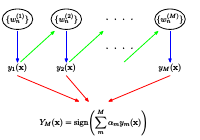

Fig.1 Schematic illustration of the boosting framework. Each base classiﬁer $y_m (x)$ is trained on a weighted form of the training set (blue arrows) in which (m) the weights wn depend on the performance of the previous base classiﬁer $y_(m−1) (x)$ (green arrows). Once all base classiﬁers have been trained, they are combined to give the ﬁnal classiﬁer $Y_M(x)$ (red arrows).


## Example
Using the AdaBoost algorithm, a sequence of decision stumps (simple classifiers that split data at a threshold) is trained. Misclassified points influence the next stump, creating a strong classifier from weak learners.


In [ ]:
# AdaBoost Implementation in Python

class AdaBoost:
    def __init__(self, num_classifiers):
        self.num_classifiers = num_classifiers  # Number of weak classifiers
        self.alphas = []  # Alpha values for the classifiers
        self.classifiers = []  # List to store weak classifiers

    def train(self, X, y):
        """
        Train AdaBoost on the given dataset.
        :param X: List of input features (2D array: N x D)
        :param y: List of target labels (-1 or 1)
        """
        # Initialize weights
        N = len(X)
        weights = [1 / N for _ in range(N)]

        for m in range(self.num_classifiers):
            # Train weak classifier
            classifier = self._train_weak_classifier(X, y, weights)
            predictions = [classifier(x) for x in X]

            # Calculate weighted error
            error = sum(weights[i] * (predictions[i] != y[i]) for i in range(N))

            # Avoid division by zero
            if error == 0:
                break

            # Calculate alpha
            alpha = 0.5 * (math.log((1 - error) / error))
            self.alphas.append(alpha)
            self.classifiers.append(classifier)

            # Update weights
            for i in range(N):
                weights[i] *= math.exp(alpha * (predictions[i] != y[i]))

            # Normalize weights
            total_weight = sum(weights)
            weights = [w / total_weight for w in weights]

    def predict(self, x):
        """
        Predict the class label for a given input.
        :param x: Input feature vector
        :return: Predicted class label (-1 or 1)
        """
        weighted_sum = sum(alpha * classifier(x) for alpha, classifier in zip(self.alphas, self.classifiers))
        return 1 if weighted_sum >= 0 else -1

    def _train_weak_classifier(self, X, y, weights):
        """
        Train a weak classifier (decision stump) on weighted data.
        :param X: List of input features
        :param y: List of target labels (-1 or 1)
        :param weights: List of data point weights
        :return: Weak classifier function
        """
        # Here we implement a simple decision stump (threshold on one feature)
        best_feature, best_threshold, best_polarity, min_error = None, None, None, float('inf')
        
        num_features = len(X[0])
        for feature_index in range(num_features):
            # Extract unique thresholds for this feature
            thresholds = set(x[feature_index] for x in X)

            for threshold in thresholds:
                for polarity in [-1, 1]:
                    # Classify based on threshold and polarity
                    predictions = [polarity * (1 if x[feature_index] > threshold else -1) for x in X]

                    # Compute weighted error
                    error = sum(weights[i] * (predictions[i] != y[i]) for i in range(len(y)))

                    if error < min_error:
                        best_feature, best_threshold, best_polarity, min_error = feature_index, threshold, polarity, error

        # Return a weak classifier function
        def weak_classifier(x):
            return best_polarity * (1 if x[best_feature] > best_threshold else -1)

        return weak_classifier

# Example Usage
if __name__ == "__main__":
    import math

    # Example dataset (binary classification)
    X = [
        [2.0], [3.0], [1.0], [4.0], [5.0]
    ]
    y = [-1, -1, 1, 1, -1]

    # Train AdaBoost
    model = AdaBoost(num_classifiers=5)
    model.train(X, y)

    # Predict on new data
    test_data = [1.5, 3.5, 5.0]
    predictions = [model.predict([x]) for x in test_data]
    print("Predictions:", predictions)


## Minimizing Exponential Error

Boosting was originally motivated using statistical learning theory, leading to upper bounds on the generalization error. However, these bounds turn out to be too loose to have practical value, and the actual performance of boosting is much better than the bounds alone would suggest. Friedman et al. (2000) gave a different and very simple interpretation of boosting in terms of the sequential minimization of an exponential error function.

Consider the exponential error function defined by:

$$
E = \prod_{n=1}^{N} \exp \left( - t_n f_m(x_n) \right)
$$

where $ f_m(x) $ is a classifier defined in terms of a linear combination of base classifiers $ y_l(x) $ of the form:

$$
f_m(x) = \sum_{l=1}^{m} \alpha_l y_l(x)
$$

and $ t_n \in \{-1, 1\} $ are the training set target values. Our goal is to minimize $ E $ with respect to both the weighting coefficients $ \alpha_l $ and the parameters of the base classifiers $ y_l(x) $.

### Sequential Minimization

Instead of performing a global error function minimization, we assume that the base classifiers $ y_1(x), \dots, y_{m-1}(x) $ are fixed, as are their coefficients $ \alpha_1, \dots, \alpha_{m-1} $, and so we are minimizing only with respect to $ \alpha_m $ and $ y_m(x) $.

By separating off the contribution from base classifier $ y_m(x) $, we can rewrite the error function in the form:

$$
E = \prod_{n=1}^{N} \exp \left( - \frac{t_n f_{m-1}(x_n) + t_n \alpha_m y_m(x_n)}{2} \right)
$$

which can be expressed as:

$$
E = \prod_{n=1}^{N} w_n \exp \left( - \frac{t_n \alpha_m y_m(x_n)}{2} \right)
$$

where the coefficients $ w_n = \exp \left( - t_n f_{m-1}(x_n) \right) $ are treated as constants because we are optimizing only $ \alpha_m $ and $ y_m(x) $.

### Correctly and Misclassified Points

Denote by $ T_m $ the set of data points that are correctly classified by $ y_m(x) $, and by $ M_m $ the misclassified points. We can then rewrite the error function in the form:

$$
E = \exp \left( \frac{\alpha_m}{2} \right) \sum_{n \in T_m} w_n + \exp \left( - \frac{\alpha_m}{2} \right) \sum_{n \in M_m} w_n
$$

When minimizing this with respect to $ y_m(x) $, the second term is constant, so this is equivalent to minimizing:

$$
\sum_{n \in M_m} w_n \exp \left( - \frac{\alpha_m}{2} \right)
$$

Similarly, minimizing with respect to $ \alpha_m $, we obtain the optimal $ \alpha_m $ as defined by:

$$
\alpha_m = \frac{1}{2} \ln \left( \frac{\sum_{n \in M_m} w_n}{\sum_{n \in T_m} w_n} \right)
$$

### Updating Weights

Once we have $ \alpha_m $ and $ y_m(x) $, the weights on the data points are updated using:

$$
w_n^{(m+1)} = w_n^{(m)} \exp \left( - \frac{t_n \alpha_m y_m(x_n)}{2} \right)
$$

Using the fact that $ t_n y_m(x_n) = 1 - 2I(y_m(x_n) = t_n) $, we can rewrite this as:

$$
w_n^{(m+1)} = w_n^{(m)} \exp \left( - \frac{\alpha_m}{2} \right) \exp \left( \alpha_m I(y_m(x_n) = t_n) \right)
$$

Since $ \exp \left( - \frac{\alpha_m}{2} \right) $ is independent of $ n $, we can discard it, and the weights are updated as:

$$
w_n^{(m+1)} = w_n^{(m)} \exp \left( \alpha_m I(y_m(x_n) = t_n) \right)
$$

### Final Classifier

Finally, once all the base classifiers are trained, new data points are classified by evaluating the sign of the combined function defined as:

$$
f(x) = \sum_{m=1}^{M} \alpha_m y_m(x)
$$

Because the factor of $ \frac{1}{2} $ does not affect the sign, it can be omitted, giving:

$$
\text{sign}\left( f(x) \right) = \text{sign}\left( \sum_{m=1}^{M} \alpha_m y_m(x) \right)
$$

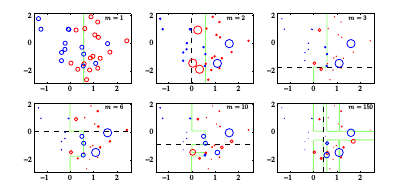

Fig.2 Illustration of boosting in which the base learners consist of simple thresholds applied to one or other of the axes. Each ﬁgure shows the number m of base learners trained so far, along with the decision boundary of the most recent base learner (dashed black line) and the combined decision boundary of the en- semble (solid green line). Each data point is depicted by a circle whose radius indicates the weight assigned to that data point when training the most recently added base learner. Thus, for instance, we see that points that are misclassiﬁed by the m = 1 base learner are given greater weight when training the m = 2 base learner.


Accuracy: 77.00%


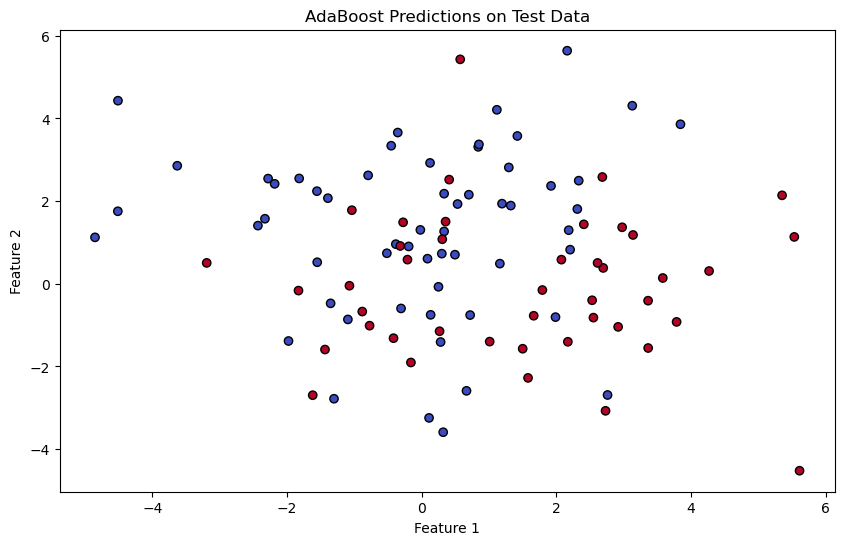

In [3]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class AdaBoost:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.alphas = []  # Coefficients for each base classifier
        self.models = []  # List of base classifiers

    def fit(self, X, y):
        n_samples, n_features = X.shape
        w = np.ones(n_samples) / n_samples  # Initialize weights equally for all samples

        for m in range(self.n_estimators):
            # Train a weak classifier (decision stump)
            model = DecisionTreeClassifier(max_depth=1)
            model.fit(X, y, sample_weight=w)

            # Get predictions and error
            y_pred = model.predict(X)
            incorrect = (y_pred != y)

            # Compute model error
            err = np.sum(w * incorrect) / np.sum(w)
            
            # Compute the model weight (alpha)
            alpha = 0.5 * np.log((1 - err) / (err + 1e-10))
            
            # Update sample weights
            w = w * np.exp(-alpha * y * y_pred)
            w = w / np.sum(w)  # Normalize the weights
            
            # Store model and alpha
            self.models.append(model)
            self.alphas.append(alpha)

    def predict(self, X):
        # Get weighted sum of predictions from each base classifier
        pred = np.zeros(X.shape[0])
        for model, alpha in zip(self.models, self.alphas):
            pred += alpha * model.predict(X)
        return np.sign(pred)

# Generate a simple binary classification dataset
X, y = make_classification(n_samples=500, n_features=20, n_informative=10, n_classes=2, random_state=42)
y = 2*y - 1  # Change labels to be -1 and 1 (AdaBoost convention)

# Split into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train AdaBoost model
model = AdaBoost(n_estimators=50)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot the decision boundary (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='coolwarm', marker='o', edgecolors='k')
plt.title("AdaBoost Predictions on Test Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


Accuracy: 92.00%


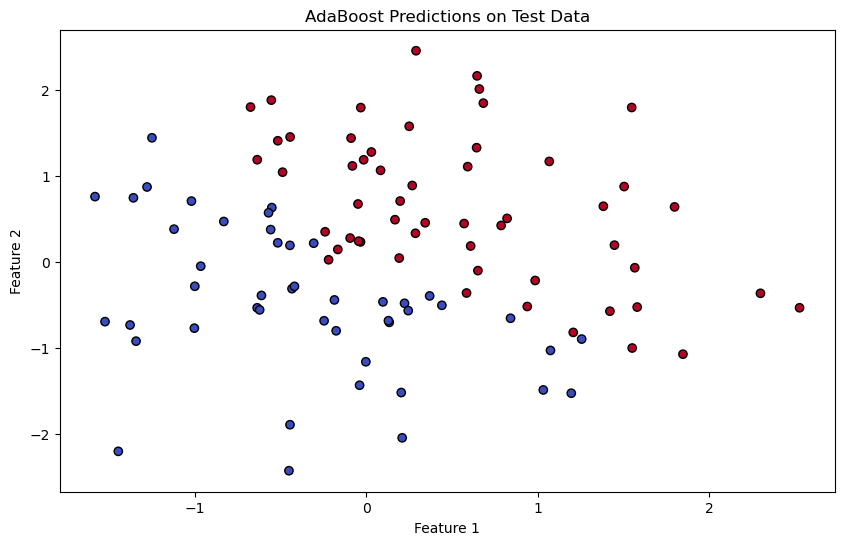

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class DecisionStump:
    def __init__(self):
        self.alpha = 0  # Coefficient (weight) of the decision stump
        self.feature = 0  # Feature index used for the split
        self.threshold = 0  # Threshold value for classification

    def fit(self, X, y, sample_weight):
        # Initialize best error to a large number
        best_error = float('inf')
        
        n_samples, n_features = X.shape
        best_threshold = 0
        best_feature = 0
        best_polarity = 1  # 1 or -1 for "greater than" or "less than"

        # Loop over each feature
        for feature in range(n_features):
            # Sort data by the chosen feature to find potential thresholds
            sorted_indices = np.argsort(X[:, feature])
            sorted_X = X[sorted_indices]
            sorted_y = y[sorted_indices]
            sorted_weight = sample_weight[sorted_indices]
            
            # Check all potential thresholds (midpoints between consecutive values)
            for i in range(1, n_samples):
                threshold = (sorted_X[i-1, feature] + sorted_X[i, feature]) / 2
                # Evaluate both polarities (whether threshold is less than or greater than)
                for polarity in [1, -1]:
                    pred = np.ones(n_samples)
                    pred[polarity * sorted_X[:, feature] < polarity * threshold] = -1
                    error = np.sum(sorted_weight * (pred != sorted_y))
                    
                    # Update best error if found a better threshold
                    if error < best_error:
                        best_error = error
                        best_threshold = threshold
                        best_feature = feature
                        best_polarity = polarity
        
        # Set the learned parameters
        self.feature = best_feature
        self.threshold = best_threshold
        self.polarity = best_polarity
        self.alpha = 0.5 * np.log((1 - best_error) / (best_error + 1e-10))

    def predict(self, X):
        n_samples = X.shape[0]
        pred = np.ones(n_samples)
        if self.polarity == 1:
            pred[X[:, self.feature] <= self.threshold] = -1
        else:
            pred[X[:, self.feature] > self.threshold] = -1
        return pred

class AdaBoost:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.models = []  # List to store each weak classifier (Decision Stump)
        self.alphas = []  # List to store the alphas (weights for each classifier)

    def fit(self, X, y):
        n_samples = X.shape[0]
        sample_weight = np.ones(n_samples) / n_samples  # Initialize sample weights equally

        for _ in range(self.n_estimators):
            # Create a new decision stump (weak classifier)
            stump = DecisionStump()
            stump.fit(X, y, sample_weight)  # Fit the stump
            predictions = stump.predict(X)  # Get predictions from the stump

            # Calculate error rate
            err = np.sum(sample_weight * (predictions != y)) / np.sum(sample_weight)

            # Compute the classifier weight (alpha)
            alpha = 0.5 * np.log((1 - err) / (err + 1e-10))

            # Update sample weights
            sample_weight *= np.exp(-alpha * y * predictions)
            sample_weight /= np.sum(sample_weight)  # Normalize weights

            # Store the classifier and its corresponding weight
            self.models.append(stump)
            self.alphas.append(alpha)

    def predict(self, X):
        # Calculate the weighted sum of predictions from all weak classifiers
        pred = np.zeros(X.shape[0])
        for model, alpha in zip(self.models, self.alphas):
            pred += alpha * model.predict(X)

        # The final prediction is the sign of the weighted sum
        return np.sign(pred)

# Generate a simple binary classification dataset (manual)
def generate_data():
    np.random.seed(42)
    X = np.random.randn(500, 2)
    y = np.ones(500)
    y[X[:, 0] + X[:, 1] < 0] = -1
    return X, y

# Split dataset into training and testing sets (80% train, 20% test)
X, y = generate_data()
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train AdaBoost model
adaboost = AdaBoost(n_estimators=50)
adaboost.fit(X_train, y_train)

# Make predictions
y_pred = adaboost.predict(X_test)

# Evaluate the model (accuracy)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='coolwarm', marker='o', edgecolors='k')
plt.title("AdaBoost Predictions on Test Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


Accuracy: 96.00%


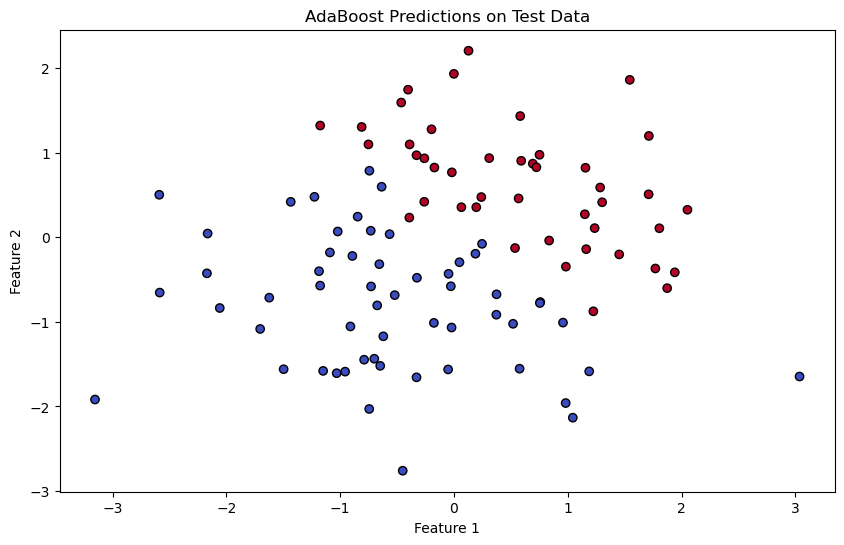

In [6]:
import random
import math
import matplotlib.pyplot as plt

class DecisionStump:
    def __init__(self):
        self.alpha = 0  # Coefficient (weight) of the decision stump
        self.feature = 0  # Feature index used for the split
        self.threshold = 0  # Threshold value for classification

    def fit(self, X, y, sample_weight):
        # Initialize best error to a large number
        best_error = float('inf')
        
        n_samples = len(X)
        best_threshold = 0
        best_feature = 0
        best_polarity = 1  # 1 or -1 for "greater than" or "less than"

        # Loop over each feature
        for feature in range(len(X[0])):
            # Sort data by the chosen feature to find potential thresholds
            sorted_indices = sorted(range(n_samples), key=lambda i: X[i][feature])
            sorted_X = [X[i] for i in sorted_indices]
            sorted_y = [y[i] for i in sorted_indices]
            sorted_weight = [sample_weight[i] for i in sorted_indices]
            
            # Check all potential thresholds (midpoints between consecutive values)
            for i in range(1, n_samples):
                threshold = (sorted_X[i-1][feature] + sorted_X[i][feature]) / 2
                # Evaluate both polarities (whether threshold is less than or greater than)
                for polarity in [1, -1]:
                    pred = [1 if polarity * sorted_X[j][feature] > polarity * threshold else -1 for j in range(n_samples)]
                    error = sum(sorted_weight[j] for j in range(n_samples) if pred[j] != sorted_y[j])

                    # Update best error if found a better threshold
                    if error < best_error:
                        best_error = error
                        best_threshold = threshold
                        best_feature = feature
                        best_polarity = polarity
        
        # Set the learned parameters
        self.feature = best_feature
        self.threshold = best_threshold
        self.polarity = best_polarity
        self.alpha = 0.5 * (math.log((1 - best_error) / (best_error + 1e-10)) if best_error != 0 else 0)

    def predict(self, X):
        n_samples = len(X)
        pred = [1 if self.polarity * X[i][self.feature] > self.polarity * self.threshold else -1 for i in range(n_samples)]
        return pred

class AdaBoost:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.models = []  # List to store each weak classifier (Decision Stump)
        self.alphas = []  # List to store the alphas (weights for each classifier)

    def fit(self, X, y):
        n_samples = len(X)
        sample_weight = [1 / n_samples] * n_samples  # Initialize sample weights equally

        for _ in range(self.n_estimators):
            # Create a new decision stump (weak classifier)
            stump = DecisionStump()
            stump.fit(X, y, sample_weight)  # Fit the stump
            predictions = stump.predict(X)  # Get predictions from the stump

            # Calculate error rate
            err = sum(sample_weight[i] for i in range(n_samples) if predictions[i] != y[i]) / sum(sample_weight)

            # Compute the classifier weight (alpha)
            alpha = 0.5 * (math.log((1 - err) / (err + 1e-10)) if err != 0 else 0)

            # Update sample weights
            sample_weight = [sample_weight[i] * math.exp(-alpha * y[i] * predictions[i]) for i in range(n_samples)]
            sample_weight_sum = sum(sample_weight)
            sample_weight = [w / sample_weight_sum for w in sample_weight]  # Normalize weights

            # Store the classifier and its corresponding weight
            self.models.append(stump)
            self.alphas.append(alpha)

    def predict(self, X):
        # Calculate the weighted sum of predictions from all weak classifiers
        n_samples = len(X)
        pred = [0] * n_samples
        for model, alpha in zip(self.models, self.alphas):
            stump_pred = model.predict(X)
            pred = [pred[i] + alpha * stump_pred[i] for i in range(n_samples)]

        # The final prediction is the sign of the weighted sum
        return [1 if p >= 0 else -1 for p in pred]

# Generate a simple binary classification dataset (manual)
def generate_data():
    random.seed(42)
    X = [[random.gauss(0, 1), random.gauss(0, 1)] for _ in range(500)]
    y = [1 if x[0] + x[1] > 0 else -1 for x in X]
    return X, y

# Split dataset into training and testing sets (80% train, 20% test)
X, y = generate_data()
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train AdaBoost model
adaboost = AdaBoost(n_estimators=50)
adaboost.fit(X_train, y_train)

# Make predictions
y_pred = adaboost.predict(X_test)

# Evaluate the model (accuracy)
accuracy = sum(1 for i in range(len(y_test)) if y_pred[i] == y_test[i]) / len(y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.scatter([x[0] for x in X_test], [x[1] for x in X_test], c=y_pred, cmap='coolwarm', marker='o', edgecolors='k')
plt.title("AdaBoost Predictions on Test Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


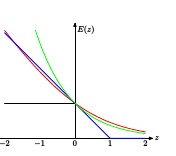

Fig.3 Plot of the exponential (green) and rescaled cross-entropy (red) error functions along with the hinge error (blue) used in support vector machines, and the misclassiﬁcation error (black). Note that for large negative values of z = ty(x), the cross-entropy gives a linearly increasing penalty, whereas the expo- nential loss gives an exponentially increasing penalty.

## Error Functions for Boosting

The exponential error function minimized by the AdaBoost algorithm differs from those considered in previous chapters. To gain insight into the exponential error function, we start with the expected error:

$$
\mathbb{E}_{x,t}\left[\exp\{-ty(x)\}\right] = \int \exp\{-ty(x)\} p(t|x)p(x) dx.
\tag{14.27}
$$

If we perform a variational minimization with respect to all possible functions $ y(x) $, we obtain:

$$
y(x) = \frac{1}{2} \ln \frac{p(t = 1|x)}{p(t = -1|x)}.
\tag{14.28}
$$

This result shows that AdaBoost seeks the best approximation to the log-odds ratio within the space of functions represented by the linear combination of base classifiers, subject to the constraints of sequential optimization. 

This finding also motivates the use of the sign function in the final classification decision:

$$
\text{sign}\left(\sum_m \alpha_m y_m(x)\right).
\tag{14.19}
$$

## Comparison of Error Functions

The minimizer $ y(x) $ of the **cross-entropy error** for two-class classification is the posterior class probability. For a target variable $ t \in \{-1, 1\} $, the cross-entropy error is given by:

$$
\ln(1 + \exp(-yt)).
$$

In the following figure, the exponential error function is compared with the rescaled cross-entropy error and other error functions:

### Fig.3
- **Exponential Error (green)**
- **Rescaled Cross-Entropy Error (red)**
- **Hinge Error (blue, used in SVMs)**
- **Misclassification Error (black)**

Note that for large negative values of $ z = ty(x) $:
- Cross-entropy grows linearly with $ |ty| $,
- Exponential error grows exponentially with $ |ty| $.

The exponential error is therefore **less robust** to outliers or misclassified data points.

### Key Properties of Error Functions
1. The exponential error function:
   - Does not generalize to $ K > 2 $ classes.
   - Cannot be interpreted as the log-likelihood of any well-defined probabilistic model.
   - Enables simple sequential minimization in AdaBoost.

2. Cross-entropy error:
   - Grows linearly for large negative values of $ z $.
   - Generalizes easily to multiclass problems.

## Extensions of Boosting Algorithms

The interpretation of boosting as sequential optimization of an additive model under an exponential error (Friedman et al., 2000) leads to:
- **Multiclass extensions**: By altering the choice of error function.
- **Regression problems**: Using a sum-of-squares error function.

For regression, sequential minimization involves fitting each new base classifier to the residuals:

$$
r_n = t_n - f_{m-1}(x_n).
$$

However, the sum-of-squares error is not robust to outliers. An alternative is the **absolute error**:

$$
|y - t|.
$$

### Fig.4
- **Squared Error (green)** vs. **Absolute Error (red)**:
  - Absolute error is more robust to outliers and mislabeled data points.

The following figures illustrate the differences:

### Fig.3
Comparing the error functions for classification.

### Fig.4
Comparing the error functions for regression.



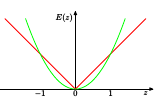

Fig.4 Comparison of the squared error (green) with the absolute error (red) showing how the latter places much less emphasis on large errors and hence is more robust to outliers and mislabelled data points.

In [7]:
import math

# Define exponential error function
def exponential_error(t, y):
    """
    Computes the exponential error function E = exp(-ty)
    t: Target value (-1 or 1)
    y: Predicted value
    """
    return math.exp(-t * y)

# Define cross-entropy error function
def cross_entropy_error(t, y):
    """
    Computes the cross-entropy error function E = ln(1 + exp(-ty))
    t: Target value (-1 or 1)
    y: Predicted value
    """
    return math.log(1 + math.exp(-t * y))

# Define hinge error function
def hinge_error(t, y):
    """
    Computes the hinge error function E = max(0, 1 - ty)
    t: Target value (-1 or 1)
    y: Predicted value
    """
    return max(0, 1 - t * y)

# Define misclassification error function
def misclassification_error(t, y):
    """
    Computes the misclassification error E = 1 if ty < 0, else 0
    t: Target value (-1 or 1)
    y: Predicted value
    """
    return 1 if t * y < 0 else 0

# Define squared error function
def squared_error(t, y):
    """
    Computes the squared error function E = (y - t)^2
    t: Target value (real-valued)
    y: Predicted value
    """
    return (y - t) ** 2

# Define absolute error function
def absolute_error(t, y):
    """
    Computes the absolute error function E = |y - t|
    t: Target value (real-valued)
    y: Predicted value
    """
    return abs(y - t)

# Test the functions with example inputs
if __name__ == "__main__":
    t = 1  # Target
    y = 0.5  # Prediction

    print("Exponential Error:", exponential_error(t, y))
    print("Cross-Entropy Error:", cross_entropy_error(t, y))
    print("Hinge Error:", hinge_error(t, y))
    print("Misclassification Error:", misclassification_error(t, y))
    print("Squared Error:", squared_error(t, y))
    print("Absolute Error:", absolute_error(t, y))


Exponential Error: 0.6065306597126334
Cross-Entropy Error: 0.4740769841801067
Hinge Error: 0.5
Misclassification Error: 0
Squared Error: 0.25
Absolute Error: 0.5
